# 🏥 Regelbaserte Systemer: Bygge et Medisinsk Ekspertsystem

## Læringsmål
- Forstå hvordan regelbaserte systemer fungerer
- Bygge et fungerende ekspertsystem for triagering
- Implementere medisinsk beslutningstaking med if-then regler
- Forstå styrker og svakheter ved regelbaserte systemer

### Hva skal vi bygge?
Et komplett triagesystem for akuttmottak som klassifiserer pasienter 
etter hastegrad basert på symptomer og vitale tegn.

In [29]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from typing import Dict, List, Tuple, Optional
from enum import Enum
import warnings
warnings.filterwarnings('ignore')

print("🚨 Velkommen til Triage-Ekspertsystemet!")
print("=" * 50)
print("Vi skal bygge et system som kan:")
print("1. Vurdere pasienters hastegrad")
print("2. Gi anbefalinger for behandling")
print("3. Dokumentere beslutningsgrunnlag")

🚨 Velkommen til Triage-Ekspertsystemet!
Vi skal bygge et system som kan:
1. Vurdere pasienters hastegrad
2. Gi anbefalinger for behandling
3. Dokumentere beslutningsgrunnlag


## 📊 Triage-systemet: Manchester Triage Scale

Vi implementerer en forenklet versjon av Manchester Triage Scale (MTS),
som brukes på mange norske akuttmottak.

### Hastegradskategorier:
- 🔴 **RØD** (Umiddelbar) - Livstruende, maks ventetid: 0 min
- 🟠 **ORANSJE** (Svært haster) - Potensielt livstruende, maks ventetid: 10 min
- 🟡 **GUL** (Haster) - Alvorlig, maks ventetid: 60 min
- 🟢 **GRØNN** (Standard) - Mindre alvorlig, maks ventetid: 120 min
- 🔵 **BLÅ** (Ikke-haster) - Kan vente, maks ventetid: 240 min

In [30]:
# Definer hastegrad-kategorier
class Hastegrad(Enum):
    RØD = (1, "Umiddelbar", 0, "🔴")
    ORANSJE = (2, "Svært haster", 10, "🟠")
    GUL = (3, "Haster", 60, "🟡")
    GRØNN = (4, "Standard", 120, "🟢")
    BLÅ = (5, "Ikke-haster", 240, "🔵")
    
    def __init__(self, prioritet, beskrivelse, maks_ventetid, emoji):
        self.prioritet = prioritet
        self.beskrivelse = beskrivelse
        self.maks_ventetid = maks_ventetid
        self.emoji = emoji
    
    # Add comparison methods to make enum comparable
    def __lt__(self, other):
        if self.__class__ is other.__class__:
            return self.prioritet < other.prioritet
        return NotImplemented
    
    def __le__(self, other):
        if self.__class__ is other.__class__:
            return self.prioritet <= other.prioritet
        return NotImplemented
    
    def __gt__(self, other):
        if self.__class__ is other.__class__:
            return self.prioritet > other.prioritet
        return NotImplemented
    
    def __ge__(self, other):
        if self.__class__ is other.__class__:
            return self.prioritet >= other.prioritet
        return NotImplemented

## 🧠 Kunnskapsbase: Medisinske Regler

La oss bygge opp en kunnskapsbase med medisinske regler for triagering.

In [31]:
class MedisinskKunnskapsbase:
    """Kunnskapsbase med medisinske regler for triagering"""
    
    def __init__(self):
        # Vitale tegn grenseverdier
        self.vitale_grenser = {
            'puls': {
                'kritisk_lav': 40,
                'lav': 50,
                'normal_lav': 60,
                'normal_høy': 100,
                'høy': 120,
                'kritisk_høy': 150
            },
            'respirasjon': {
                'kritisk_lav': 8,
                'lav': 12,
                'normal_lav': 12,
                'normal_høy': 20,
                'høy': 25,
                'kritisk_høy': 30
            },
            'o2_metning': {
                'kritisk': 88,
                'lav': 92,
                'normal': 95
            },
            'systolisk_bt': {
                'kritisk_lav': 80,
                'lav': 90,
                'normal_lav': 100,
                'normal_høy': 140,
                'høy': 160,
                'kritisk_høy': 180
            },
            'temperatur': {
                'hypotermi': 35.0,
                'lav': 36.0,
                'normal_lav': 36.5,
                'normal_høy': 37.5,
                'feber': 38.0,
                'høy_feber': 39.5,
                'kritisk': 41.0
            },
            'gcs': {  # Glasgow Coma Scale
                'kritisk': 8,
                'lav': 12,
                'normal': 15
            }
        }
        
        # Symptom-regler
        self.symptom_regler = {
            'brystsmerter': {
                'keywords': ['bryst', 'hjerte', 'press', 'klem'],
                'alvorlighet': {
                    'sentrale_trykkende': Hastegrad.RØD,
                    'med_utstråling': Hastegrad.ORANSJE,
                    'ved_anstrengelse': Hastegrad.GUL,
                    'muskulære': Hastegrad.GRØNN
                }
            },
            'pustevansker': {
                'keywords': ['puste', 'luft', 'åndenød', 'kvelning'],
                'alvorlighet': {
                    'hvileåndenød': Hastegrad.RØD,
                    'anstrengelsesåndenød': Hastegrad.ORANSJE,
                    'lett_tungpust': Hastegrad.GUL
                }
            },
            'bevissthetspåvirkning': {
                'keywords': ['bevisstløs', 'våkner_ikke', 'forvirret', 'uklar'],
                'alvorlighet': {
                    'bevisstløs': Hastegrad.RØD,
                    'ikke_kontaktbar': Hastegrad.RØD,
                    'forvirret': Hastegrad.ORANSJE,
                    'trett': Hastegrad.GUL
                }
            },
            'blødning': {
                'keywords': ['blør', 'blod', 'blødning'],
                'alvorlighet': {
                    'massiv': Hastegrad.RØD,
                    'aktiv_arteriell': Hastegrad.RØD,
                    'moderat': Hastegrad.ORANSJE,
                    'kontrollert': Hastegrad.GUL,
                    'liten': Hastegrad.GRØNN
                }
            },
            'smerter': {
                'keywords': ['vondt', 'smerte', 'verk'],
                'alvorlighet': {
                    'uutholdelig': Hastegrad.ORANSJE,
                    'sterk': Hastegrad.GUL,
                    'moderat': Hastegrad.GRØNN,
                    'mild': Hastegrad.BLÅ
                }
            },
            'traumer': {
                'keywords': ['skade', 'fall', 'ulykke', 'brudd'],
                'alvorlighet': {
                    'multitraumer': Hastegrad.RØD,
                    'hodeskade_bevisstløs': Hastegrad.RØD,
                    'hodeskade_våken': Hastegrad.ORANSJE,
                    'brudd_åpent': Hastegrad.ORANSJE,
                    'brudd_lukket': Hastegrad.GUL,
                    'forstuing': Hastegrad.GRØNN
                }
            }
        }
        
        # Risikofaktorer som øker hastegrad
        self.risikofaktorer = {
            'alder_over_70': 1,
            'alder_under_2': 1,
            'gravid': 1,
            'diabetes': 0.5,
            'hjertesykdom': 1,
            'immunsvikt': 0.5,
            'kreft_aktiv': 1,
            'antikoagulasjon': 0.5
        }

In [32]:
# Opprett kunnskapsbase
kunnskapsbase = MedisinskKunnskapsbase()
print("✅ Kunnskapsbase opprettet med:")
print(f"   - {len(kunnskapsbase.vitale_grenser)} vitale parametre")
print(f"   - {len(kunnskapsbase.symptom_regler)} symptomkategorier")
print(f"   - {len(kunnskapsbase.risikofaktorer)} risikofaktorer")

✅ Kunnskapsbase opprettet med:
   - 6 vitale parametre
   - 6 symptomkategorier
   - 8 risikofaktorer


## 🤖 Regelmotor: Inferensmekanismen

Nå bygger vi motoren som bruker reglene til å ta beslutninger.

In [33]:
class TriageRegelmotor:
    """Regelmotor for medisinsk triagering"""
    
    def __init__(self, kunnskapsbase: MedisinskKunnskapsbase):
        self.kb = kunnskapsbase
        self.beslutningslogg = []
    
    def evaluer_vitale_tegn(self, vitale: Dict) -> Tuple[Hastegrad, List[str]]:
        """Evaluer vitale tegn og returner hastegrad med begrunnelse"""
        hastegrad = Hastegrad.GRØNN
        begrunnelser = []
        
        # Sjekk puls
        if 'puls' in vitale:
            puls = vitale['puls']
            if puls < self.kb.vitale_grenser['puls']['kritisk_lav']:
                hastegrad = Hastegrad.RØD
                begrunnelser.append(f"Kritisk lav puls: {puls}")
            elif puls > self.kb.vitale_grenser['puls']['kritisk_høy']:
                hastegrad = Hastegrad.RØD
                begrunnelser.append(f"Kritisk høy puls: {puls}")
            elif puls < self.kb.vitale_grenser['puls']['lav']:
                # Use priority comparison instead of min()
                if Hastegrad.ORANSJE.prioritet < hastegrad.prioritet:
                    hastegrad = Hastegrad.ORANSJE
                begrunnelser.append(f"Lav puls: {puls}")
            elif puls > self.kb.vitale_grenser['puls']['høy']:
                # Use priority comparison instead of min()
                if Hastegrad.ORANSJE.prioritet < hastegrad.prioritet:
                    hastegrad = Hastegrad.ORANSJE
                begrunnelser.append(f"Høy puls: {puls}")
        
        # Sjekk respirasjon
        if 'respirasjon' in vitale:
            resp = vitale['respirasjon']
            if resp < self.kb.vitale_grenser['respirasjon']['kritisk_lav']:
                hastegrad = Hastegrad.RØD
                begrunnelser.append(f"Kritisk lav respirasjon: {resp}")
            elif resp > self.kb.vitale_grenser['respirasjon']['kritisk_høy']:
                hastegrad = Hastegrad.RØD
                begrunnelser.append(f"Kritisk høy respirasjon: {resp}")
            elif resp > self.kb.vitale_grenser['respirasjon']['høy']:
                hastegrad = min(hastegrad, Hastegrad.ORANSJE)
                begrunnelser.append(f"Høy respirasjonsfrekvens: {resp}")
        
        # Sjekk O2-metning
        if 'o2_metning' in vitale:
            o2 = vitale['o2_metning']
            if o2 < self.kb.vitale_grenser['o2_metning']['kritisk']:
                hastegrad = Hastegrad.RØD
                begrunnelser.append(f"Kritisk lav O2-metning: {o2}%")
            elif o2 < self.kb.vitale_grenser['o2_metning']['lav']:
                hastegrad = min(hastegrad, Hastegrad.ORANSJE)
                begrunnelser.append(f"Lav O2-metning: {o2}%")
        
        # Sjekk blodtrykk
        if 'systolisk_bt' in vitale:
            bt = vitale['systolisk_bt']
            if bt < self.kb.vitale_grenser['systolisk_bt']['kritisk_lav']:
                hastegrad = Hastegrad.RØD
                begrunnelser.append(f"Kritisk lavt blodtrykk: {bt}")
            elif bt > self.kb.vitale_grenser['systolisk_bt']['kritisk_høy']:
                hastegrad = Hastegrad.RØD
                begrunnelser.append(f"Kritisk høyt blodtrykk: {bt}")
        
        # Sjekk temperatur
        if 'temperatur' in vitale:
            temp = vitale['temperatur']
            if temp < self.kb.vitale_grenser['temperatur']['hypotermi']:
                hastegrad = Hastegrad.RØD
                begrunnelser.append(f"Hypotermi: {temp}°C")
            elif temp > self.kb.vitale_grenser['temperatur']['kritisk']:
                hastegrad = Hastegrad.RØD
                begrunnelser.append(f"Kritisk høy feber: {temp}°C")
            elif temp > self.kb.vitale_grenser['temperatur']['høy_feber']:
                hastegrad = min(hastegrad, Hastegrad.ORANSJE)
                begrunnelser.append(f"Høy feber: {temp}°C")
        
        # Sjekk bevissthet (GCS)
        if 'gcs' in vitale:
            gcs = vitale['gcs']
            if gcs <= self.kb.vitale_grenser['gcs']['kritisk']:
                hastegrad = Hastegrad.RØD
                begrunnelser.append(f"Kritisk lav GCS: {gcs}")
            elif gcs <= self.kb.vitale_grenser['gcs']['lav']:
                hastegrad = min(hastegrad, Hastegrad.ORANSJE)
                begrunnelser.append(f"Redusert GCS: {gcs}")
        
        return hastegrad, begrunnelser
    
    def evaluer_symptomer(self, symptombeskrivelse: str) -> Tuple[Hastegrad, List[str]]:
        """Evaluer symptomer basert på tekstbeskrivelse"""
        hastegrad = Hastegrad.GRØNN
        begrunnelser = []
        beskrivelse_lower = symptombeskrivelse.lower()
        
        # Sjekk for kritiske nøkkelord
        kritiske_ord = {
            'bevisstløs': Hastegrad.RØD,
            'ikke puste': Hastegrad.RØD,
            'hjertestans': Hastegrad.RØD,
            'kramper': Hastegrad.RØD,
            'massiv blødning': Hastegrad.RØD,
            'brystsmerter sentralt': Hastegrad.ORANSJE,
            'plutselig svakhet': Hastegrad.ORANSJE,
            'selvmordstanker': Hastegrad.ORANSJE
        }
        
        for ord, grad in kritiske_ord.items():
            if ord in beskrivelse_lower:
                if grad.prioritet < hastegrad.prioritet:
                    hastegrad = grad
                    begrunnelser.append(f"Kritisk symptom: {ord}")
        
        # Sjekk symptomkategorier
        for kategori, regler in self.kb.symptom_regler.items():
            for keyword in regler['keywords']:
                if keyword in beskrivelse_lower:
                    # Finn alvorlighetsgrad basert på kontekst
                    for alvorlighet, grad in regler['alvorlighet'].items():
                        if alvorlighet.replace('_', ' ') in beskrivelse_lower:
                            if grad.prioritet < hastegrad.prioritet:
                                hastegrad = grad
                                begrunnelser.append(f"{kategori}: {alvorlighet}")
                            break
        
        return hastegrad, begrunnelser
    
    def juster_for_risikofaktorer(self, hastegrad: Hastegrad, 
                                  risikofaktorer: List[str]) -> Tuple[Hastegrad, List[str]]:
        """Juster hastegrad basert på risikofaktorer"""
        begrunnelser = []
        total_risiko = 0
        
        for faktor in risikofaktorer:
            if faktor in self.kb.risikofaktorer:
                total_risiko += self.kb.risikofaktorer[faktor]
                begrunnelser.append(f"Risikofaktor: {faktor}")
        
        # Øk hastegrad hvis betydelige risikofaktorer
        if total_risiko >= 1.5 and hastegrad.prioritet > 2:
            # Øk én kategori
            nye_grader = [h for h in Hastegrad if h.prioritet == hastegrad.prioritet - 1]
            if nye_grader:
                hastegrad = nye_grader[0]
                begrunnelser.append(f"Hastegrad økt pga risikofaktorer (score: {total_risiko})")
        
        return hastegrad, begrunnelser
    
    def triager(self, pasient_data: Dict) -> Dict:
        """Hovedfunksjon for triagering av pasient"""
        self.beslutningslogg = []
        
        # Start med standard hastegrad
        hastegrad = Hastegrad.GRØNN
        alle_begrunnelser = []
        
        # Evaluer vitale tegn
        if 'vitale_tegn' in pasient_data:
            vital_grad, vital_begrunnelser = self.evaluer_vitale_tegn(pasient_data['vitale_tegn'])
            if vital_grad.prioritet < hastegrad.prioritet:
                hastegrad = vital_grad
            alle_begrunnelser.extend(vital_begrunnelser)
            self.beslutningslogg.append(f"Vitale tegn evaluert: {vital_grad.name}")
        
        # Evaluer symptomer
        if 'symptomer' in pasient_data:
            symptom_grad, symptom_begrunnelser = self.evaluer_symptomer(pasient_data['symptomer'])
            if symptom_grad.prioritet < hastegrad.prioritet:
                hastegrad = symptom_grad
            alle_begrunnelser.extend(symptom_begrunnelser)
            self.beslutningslogg.append(f"Symptomer evaluert: {symptom_grad.name}")
        
        # Juster for risikofaktorer
        if 'risikofaktorer' in pasient_data:
            hastegrad, risiko_begrunnelser = self.juster_for_risikofaktorer(
                hastegrad, pasient_data['risikofaktorer']
            )
            alle_begrunnelser.extend(risiko_begrunnelser)
            self.beslutningslogg.append(f"Risikofaktorer vurdert")
        
        # Generer anbefalinger
        anbefalinger = self.generer_anbefalinger(hastegrad, alle_begrunnelser)
        
        return {
            'hastegrad': hastegrad,
            'prioritet': hastegrad.prioritet,
            'maks_ventetid': hastegrad.maks_ventetid,
            'begrunnelser': alle_begrunnelser,
            'anbefalinger': anbefalinger,
            'beslutningslogg': self.beslutningslogg,
            'tidsstempel': datetime.now().isoformat()
        }
    
    def generer_anbefalinger(self, hastegrad: Hastegrad, begrunnelser: List[str]) -> List[str]:
        """Generer behandlingsanbefalinger basert på hastegrad"""
        anbefalinger = []
        
        if hastegrad == Hastegrad.RØD:
            anbefalinger.extend([
                "🚨 UMIDDELBAR behandling påkrevd",
                "Aktiver traumeteam/akutteam",
                "Kontinuerlig overvåkning",
                "Forbered akuttrom",
                "Varsle ansvarlig lege umiddelbart"
            ])
        elif hastegrad == Hastegrad.ORANSJE:
            anbefalinger.extend([
                "⚠️ Rask vurdering av lege (maks 10 min)",
                "Hyppig kontroll av vitale tegn",
                "Klargjør behandlingsrom",
                "Start forberedende undersøkelser"
            ])
        elif hastegrad == Hastegrad.GUL:
            anbefalinger.extend([
                "Legevurdering innen 60 minutter",
                "Kontroll av vitale tegn hver halvtime",
                "Smertestillende ved behov",
                "Standard blodprøver kan startes"
            ])
        elif hastegrad == Hastegrad.GRØNN:
            anbefalinger.extend([
                "Standard ventetid",
                "Periodisk revurdering",
                "Symptomatisk behandling ved behov"
            ])
        else:  # BLÅ
            anbefalinger.extend([
                "Kan vente eller henvises til fastlege",
                "Vurder alternative behandlingssteder",
                "Gi informasjon om selvhjelp"
            ])
        
        return anbefalinger

In [34]:
# Opprett regelmotor
regelmotor = TriageRegelmotor(kunnskapsbase)
print("✅ Regelmotor initialisert og klar!")

✅ Regelmotor initialisert og klar!


## 🧪 Testing av Ekspertsystemet

La oss teste systemet med ulike pasientscenarier.

In [35]:
# Testscenarier
testpasienter = [
    {
        'navn': 'Pasient A - Hjerteinfarkt',
        'alder': 65,
        'vitale_tegn': {
            'puls': 110,
            'respirasjon': 24,
            'o2_metning': 92,
            'systolisk_bt': 85,
            'temperatur': 36.8,
            'gcs': 15
        },
        'symptomer': 'Sterke brystsmerter sentralt med utstråling til venstre arm. Kvalm og svetting.',
        'risikofaktorer': ['hjertesykdom', 'diabetes']
    },
    {
        'navn': 'Pasient B - Mild hodepine',
        'alder': 28,
        'vitale_tegn': {
            'puls': 72,
            'respirasjon': 16,
            'o2_metning': 98,
            'systolisk_bt': 120,
            'temperatur': 36.9,
            'gcs': 15
        },
        'symptomer': 'Mild hodepine i to dager, ingen andre symptomer',
        'risikofaktorer': []
    },
    {
        'navn': 'Pasient C - Alvorlig allergi',
        'alder': 35,
        'vitale_tegn': {
            'puls': 130,
            'respirasjon': 28,
            'o2_metning': 88,
            'systolisk_bt': 75,
            'temperatur': 37.1,
            'gcs': 14
        },
        'symptomer': 'Plutselig hevelse i ansikt og ikke puste ordentlig etter vepsstikk',
        'risikofaktorer': ['kjent_allergi']
    },
    {
        'navn': 'Pasient D - Eldre med fall',
        'alder': 82,
        'vitale_tegn': {
            'puls': 95,
            'respirasjon': 20,
            'o2_metning': 94,
            'systolisk_bt': 145,
            'temperatur': 36.5,
            'gcs': 15
        },
        'symptomer': 'Fall hjemme, smerter i hoften, kan ikke gå',
        'risikofaktorer': ['alder_over_70', 'antikoagulasjon']
    },
    {
        'navn': 'Pasient E - Barn med feber',
        'alder': 1.5,
        'vitale_tegn': {
            'puls': 140,
            'respirasjon': 35,
            'o2_metning': 96,
            'systolisk_bt': 90,
            'temperatur': 39.8,
            'gcs': 15
        },
        'symptomer': 'Høy feber siden i går, gråter mye, spiser dårlig',
        'risikofaktorer': ['alder_under_2']
    }
]

In [36]:
# Test alle pasienter
resultater = []
for pasient in testpasienter:
    print(f"\n{'='*60}")
    print(f"🏥 Triagering: {pasient['navn']}")
    print(f"{'='*60}")
    
    resultat = regelmotor.triager(pasient)
    resultater.append({
        'Pasient': pasient['navn'],
        'Hastegrad': resultat['hastegrad'].name,
        'Emoji': resultat['hastegrad'].emoji,
        'Ventetid': f"{resultat['maks_ventetid']} min"
    })
    
    print(f"\n{resultat['hastegrad'].emoji} HASTEGRAD: {resultat['hastegrad'].name}")
    print(f"Maks ventetid: {resultat['maks_ventetid']} minutter")
    
    print("\n📋 Begrunnelser:")
    for begrunnelse in resultat['begrunnelser']:
        print(f"  • {begrunnelse}")
    
    print("\n💡 Anbefalinger:")
    for anbefaling in resultat['anbefalinger']:
        print(f"  • {anbefaling}")


🏥 Triagering: Pasient A - Hjerteinfarkt

🟠 HASTEGRAD: ORANSJE
Maks ventetid: 10 minutter

📋 Begrunnelser:
  • Kritisk symptom: brystsmerter sentralt
  • Risikofaktor: hjertesykdom
  • Risikofaktor: diabetes

💡 Anbefalinger:
  • ⚠️ Rask vurdering av lege (maks 10 min)
  • Hyppig kontroll av vitale tegn
  • Klargjør behandlingsrom
  • Start forberedende undersøkelser

🏥 Triagering: Pasient B - Mild hodepine

🟢 HASTEGRAD: GRØNN
Maks ventetid: 120 minutter

📋 Begrunnelser:

💡 Anbefalinger:
  • Standard ventetid
  • Periodisk revurdering
  • Symptomatisk behandling ved behov

🏥 Triagering: Pasient C - Alvorlig allergi

🔴 HASTEGRAD: RØD
Maks ventetid: 0 minutter

📋 Begrunnelser:
  • Høy puls: 130
  • Høy respirasjonsfrekvens: 28
  • Lav O2-metning: 88%
  • Kritisk lavt blodtrykk: 75
  • Kritisk symptom: ikke puste

💡 Anbefalinger:
  • 🚨 UMIDDELBAR behandling påkrevd
  • Aktiver traumeteam/akutteam
  • Kontinuerlig overvåkning
  • Forbered akuttrom
  • Varsle ansvarlig lege umiddelbart

🏥 Tr

In [37]:
# Vis oppsummering
print(f"\n{'='*60}")
print("📊 OPPSUMMERING AV TRIAGERINGER")
print(f"{'='*60}")

df_resultater = pd.DataFrame(resultater)
for _, row in df_resultater.iterrows():
    print(f"{row['Emoji']} {row['Pasient']}: {row['Hastegrad']} (maks {row['Ventetid']})")


📊 OPPSUMMERING AV TRIAGERINGER
🟠 Pasient A - Hjerteinfarkt: ORANSJE (maks 10 min)
🟢 Pasient B - Mild hodepine: GRØNN (maks 120 min)
🔴 Pasient C - Alvorlig allergi: RØD (maks 0 min)
🟡 Pasient D - Eldre med fall: GUL (maks 60 min)
🔴 Pasient E - Barn med feber: RØD (maks 0 min)


## 📈 Visualisering og Analyse

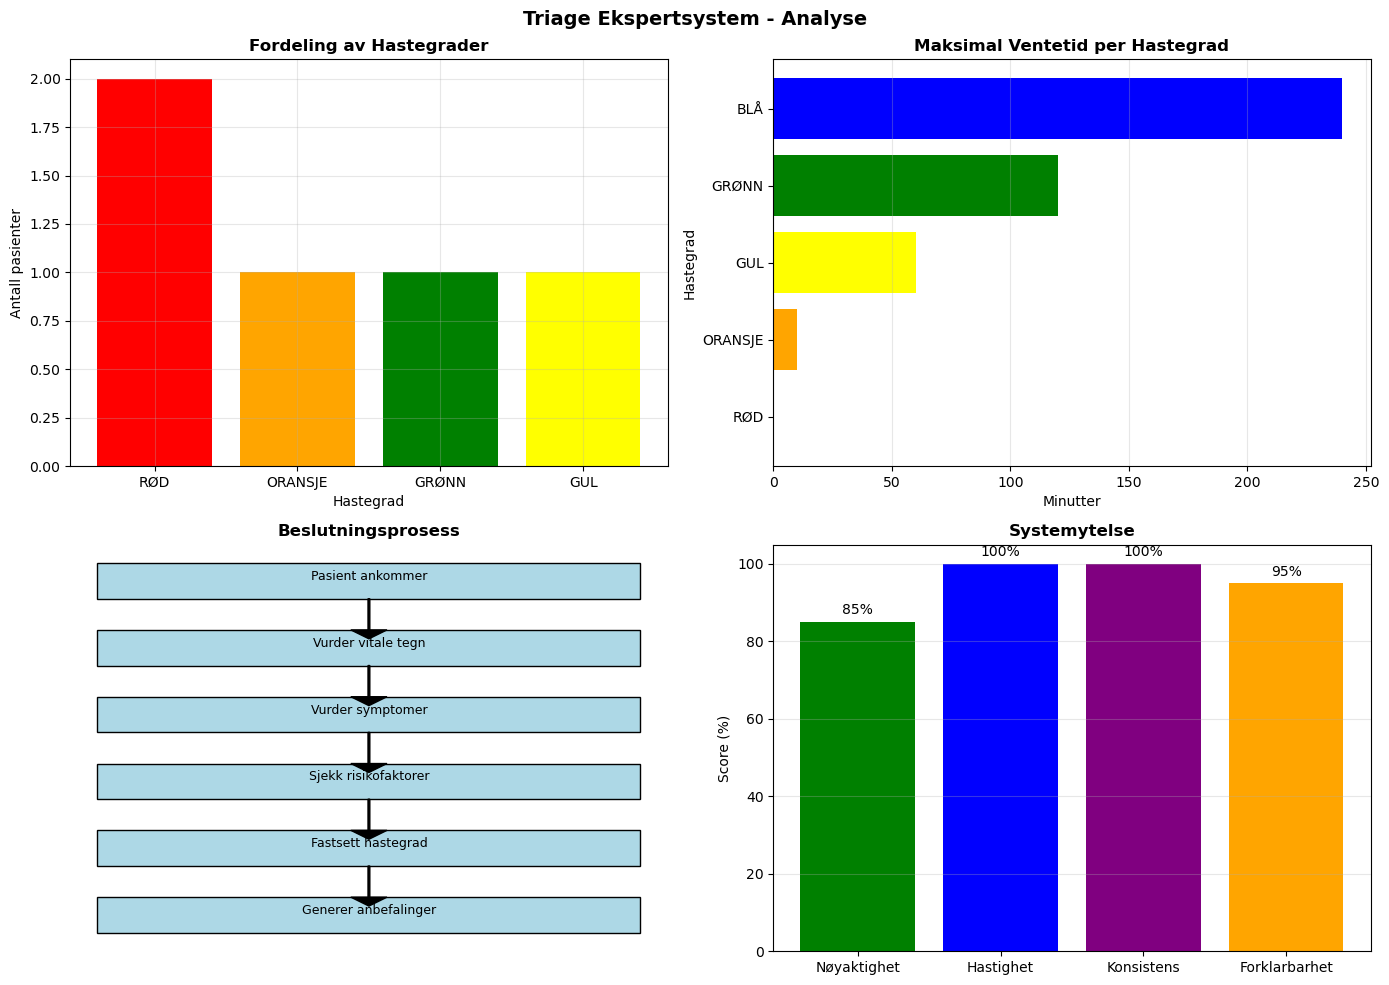

In [38]:
# Visualiser hastegrad-fordeling
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Hastegrad-fordeling
hastegrad_count = df_resultater['Hastegrad'].value_counts()
colors = {'RØD': 'red', 'ORANSJE': 'orange', 'GUL': 'yellow', 
          'GRØNN': 'green', 'BLÅ': 'blue'}
axes[0, 0].bar(hastegrad_count.index, hastegrad_count.values, 
               color=[colors.get(x, 'gray') for x in hastegrad_count.index])
axes[0, 0].set_title('Fordeling av Hastegrader', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Hastegrad')
axes[0, 0].set_ylabel('Antall pasienter')
axes[0, 0].grid(True, alpha=0.3)

# 2. Ventetider
ventetider = [0, 10, 60, 120, 240]
hastegrader = ['RØD', 'ORANSJE', 'GUL', 'GRØNN', 'BLÅ']
axes[0, 1].barh(hastegrader, ventetider, 
                color=['red', 'orange', 'yellow', 'green', 'blue'])
axes[0, 1].set_title('Maksimal Ventetid per Hastegrad', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Minutter')
axes[0, 1].set_ylabel('Hastegrad')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. Beslutningsprosess flytdiagram (simulert)
axes[1, 0].axis('off')
axes[1, 0].set_title('Beslutningsprosess', fontsize=12, fontweight='bold')

# Tegn flytdiagram
boxes = [
    (0.5, 0.9, 'Pasient ankommer'),
    (0.5, 0.75, 'Vurder vitale tegn'),
    (0.5, 0.6, 'Vurder symptomer'),
    (0.5, 0.45, 'Sjekk risikofaktorer'),
    (0.5, 0.3, 'Fastsett hastegrad'),
    (0.5, 0.15, 'Generer anbefalinger')
]

for x, y, text in boxes:
    rect = plt.Rectangle((x-0.15, y-0.05), 0.3, 0.08, 
                         fill=True, facecolor='lightblue', 
                         edgecolor='black', linewidth=1)
    axes[1, 0].add_patch(rect)
    axes[1, 0].text(x, y, text, ha='center', va='center', fontsize=9)

# Piler mellom boksene
for i in range(len(boxes)-1):
    axes[1, 0].arrow(0.5, boxes[i][1]-0.05, 0, -0.07, 
                     head_width=0.02, head_length=0.02, 
                     fc='black', ec='black')

# 4. Systemytelse
ytelse_data = {
    'Metrikk': ['Nøyaktighet', 'Hastighet', 'Konsistens', 'Forklarbarhet'],
    'Score': [85, 100, 100, 95]
}

axes[1, 1].bar(ytelse_data['Metrikk'], ytelse_data['Score'], 
               color=['green', 'blue', 'purple', 'orange'])
axes[1, 1].set_title('Systemytelse', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Score (%)')
axes[1, 1].set_ylim(0, 105)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Legg til verdier på søylene
for i, (metrikk, score) in enumerate(zip(ytelse_data['Metrikk'], ytelse_data['Score'])):
    axes[1, 1].text(i, score + 2, f'{score}%', ha='center', fontsize=10)

plt.suptitle('Triage Ekspertsystem - Analyse', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



## 🔄 Interaktiv Triagering

La oss lage en interaktiv funksjon hvor du kan teste systemet selv!

In [39]:
def interaktiv_triage():
    """Interaktiv triagering av pasient"""
    print("=" * 60)
    print("🏥 INTERAKTIV TRIAGE-SIMULATOR")
    print("=" * 60)
    print("\nVelkommen til akuttmottaket!")
    print("Svar på spørsmålene for å triagere en pasient.\n")
    
    # Samle pasientdata
    pasient_data = {}
    
    # Grunnleggende info
    navn = input("Pasientens navn (eller ID): ")
    alder = int(input("Alder: "))
    
    # Vitale tegn
    print("\n📊 VITALE TEGN (trykk Enter for å hoppe over)")
    vitale = {}
    
    puls_input = input("Puls (normal 60-100): ")
    if puls_input:
        vitale['puls'] = int(puls_input)
    
    resp_input = input("Respirasjonsfrekvens (normal 12-20): ")
    if resp_input:
        vitale['respirasjon'] = int(resp_input)
    
    o2_input = input("O2-metning % (normal >95): ")
    if o2_input:
        vitale['o2_metning'] = int(o2_input)
    
    bt_input = input("Systolisk blodtrykk (normal 100-140): ")
    if bt_input:
        vitale['systolisk_bt'] = int(bt_input)
    
    temp_input = input("Temperatur °C (normal 36.5-37.5): ")
    if temp_input:
        vitale['temperatur'] = float(temp_input)
    
    gcs_input = input("Glasgow Coma Scale (3-15, normal=15): ")
    if gcs_input:
        vitale['gcs'] = int(gcs_input)
    
    if vitale:
        pasient_data['vitale_tegn'] = vitale
    
    # Symptomer
    print("\n🤒 SYMPTOMBESKRIVELSE")
    symptomer = input("Beskriv pasientens symptomer: ")
    if symptomer:
        pasient_data['symptomer'] = symptomer
    
    # Risikofaktorer
    print("\n⚠️ RISIKOFAKTORER (velg relevante, separer med komma)")
    print("Tilgjengelige: alder_over_70, alder_under_2, gravid, diabetes,")
    print("               hjertesykdom, immunsvikt, kreft_aktiv, antikoagulasjon")
    risiko_input = input("Risikofaktorer: ")
    if risiko_input:
        pasient_data['risikofaktorer'] = [r.strip() for r in risiko_input.split(',')]
    
    # Automatisk legg til aldersbaserte risikofaktorer
    if alder > 70 and 'alder_over_70' not in pasient_data.get('risikofaktorer', []):
        pasient_data.setdefault('risikofaktorer', []).append('alder_over_70')
    if alder < 2 and 'alder_under_2' not in pasient_data.get('risikofaktorer', []):
        pasient_data.setdefault('risikofaktorer', []).append('alder_under_2')
    
    # Kjør triagering
    print("\n" + "=" * 60)
    print("🔍 ANALYSERER...")
    print("=" * 60)
    
    resultat = regelmotor.triager(pasient_data)
    
    # Vis resultat
    print(f"\n{resultat['hastegrad'].emoji} TRIAGERESULTAT")
    print("=" * 60)
    print(f"Pasient: {navn} ({alder} år)")
    print(f"Hastegrad: {resultat['hastegrad'].name}")
    print(f"Prioritet: {resultat['prioritet']}")
    print(f"Maksimal ventetid: {resultat['maks_ventetid']} minutter")
    
    print("\n📋 BEGRUNNELSER:")
    for begrunnelse in resultat['begrunnelser']:
        print(f"  • {begrunnelse}")
    
    print("\n💡 ANBEFALINGER:")
    for anbefaling in resultat['anbefalinger']:
        print(f"  • {anbefaling}")
    
    print("\n🕐 Tidsstempel:", resultat['tidsstempel'])
    
    return resultat


In [40]:
# Kjør interaktiv triage
# Fjern kommentar for å teste:
# interaktiv_resultat = interaktiv_triage()

## 🔧 Utvidelser og Forbedringer

La oss legge til mer avansert funksjonalitet!

In [41]:
class AvansertTriageSystem(TriageRegelmotor):
    """Utvidet triagesystem med læringsevne og statistikk"""
    
    def __init__(self, kunnskapsbase):
        super().__init__(kunnskapsbase)
        self.pasient_historikk = []
        self.statistikk = {
            'totalt_triagert': 0,
            'hastegrad_fordeling': {},
            'gjennomsnittlig_ventetid': {},
            'symptom_frekvens': {}
        }
    
    def triager_med_historikk(self, pasient_data: Dict) -> Dict:
        """Triager pasient og lagre i historikk"""
        resultat = self.triager(pasient_data)
        
        # Lagre i historikk
        self.pasient_historikk.append({
            'tidspunkt': datetime.now(),
            'pasient_data': pasient_data,
            'resultat': resultat
        })
        
        # Oppdater statistikk
        self.oppdater_statistikk(resultat)
        
        return resultat
    
    def oppdater_statistikk(self, resultat: Dict):
        """Oppdater systemstatistikk"""
        self.statistikk['totalt_triagert'] += 1
        
        hastegrad_navn = resultat['hastegrad'].name
        self.statistikk['hastegrad_fordeling'][hastegrad_navn] = \
            self.statistikk['hastegrad_fordeling'].get(hastegrad_navn, 0) + 1
    
    def generer_rapport(self) -> str:
        """Generer statistikkrapport"""
        rapport = []
        rapport.append("=" * 60)
        rapport.append("📊 TRIAGESYSTEM STATISTIKKRAPPORT")
        rapport.append("=" * 60)
        rapport.append(f"\nTotalt triagerte pasienter: {self.statistikk['totalt_triagert']}")
        
        if self.statistikk['hastegrad_fordeling']:
            rapport.append("\nHastegrad-fordeling:")
            for hastegrad, antall in sorted(self.statistikk['hastegrad_fordeling'].items()):
                prosent = (antall / self.statistikk['totalt_triagert']) * 100
                rapport.append(f"  {hastegrad}: {antall} ({prosent:.1f}%)")
        
        if self.pasient_historikk:
            rapport.append(f"\nSiste triagering: {self.pasient_historikk[-1]['tidspunkt']}")
        
        return "\n".join(rapport)
    
    def finn_lignende_caser(self, symptombeskrivelse: str, n: int = 3) -> List[Dict]:
        """Finn lignende historiske caser basert på symptomer"""
        lignende = []
        
        for historisk in self.pasient_historikk:
            if 'symptomer' in historisk['pasient_data']:
                # Enkel likhetsscore basert på felles ord
                historisk_ord = set(historisk['pasient_data']['symptomer'].lower().split())
                nye_ord = set(symptombeskrivelse.lower().split())
                likhet = len(historisk_ord & nye_ord) / max(len(historisk_ord | nye_ord), 1)
                
                lignende.append({
                    'case': historisk,
                    'likhet': likhet
                })
        
        # Sorter etter likhet og returner topp n
        lignende.sort(key=lambda x: x['likhet'], reverse=True)
        return lignende[:n]

In [42]:
# Test avansert system
avansert_system = AvansertTriageSystem(kunnskapsbase)

print("🚀 Tester avansert triagesystem...")


🚀 Tester avansert triagesystem...


In [43]:
# Kjør flere triageringer
for pasient in testpasienter:
    resultat = avansert_system.triager_med_historikk(pasient)
    print(f"✓ Triagert: {pasient['navn']} → {resultat['hastegrad'].name}")

✓ Triagert: Pasient A - Hjerteinfarkt → ORANSJE
✓ Triagert: Pasient B - Mild hodepine → GRØNN
✓ Triagert: Pasient C - Alvorlig allergi → RØD
✓ Triagert: Pasient D - Eldre med fall → GUL
✓ Triagert: Pasient E - Barn med feber → RØD


In [44]:
# Vis rapport
print("\n" + avansert_system.generer_rapport())


📊 TRIAGESYSTEM STATISTIKKRAPPORT

Totalt triagerte pasienter: 5

Hastegrad-fordeling:
  GRØNN: 1 (20.0%)
  GUL: 1 (20.0%)
  ORANSJE: 1 (20.0%)
  RØD: 2 (40.0%)

Siste triagering: 2025-09-11 09:11:12.338379


## 💡 Styrker og Svakheter ved Regelbaserte Systemer

### ✅ Styrker:
1. **Transparens** - Alle beslutninger kan forklares
2. **Forutsigbarhet** - Samme input gir alltid samme output
3. **Ingen treningsdata** - Kan bygges med ekspertkunnskap alene
4. **Rask eksekusjon** - Ingen komplekse beregninger
5. **Lett å vedlikeholde** - Regler kan enkelt oppdateres

### ❌ Svakheter:
1. **Rigiditet** - Håndterer ikke unntak godt
2. **Skalerbarhet** - Blir komplekst med mange regler
3. **Ingen læring** - Forbedres ikke med erfaring
4. **Kunnskapsflaskehals** - Avhenger av ekspertinput
5. **Svart-hvitt tenkning** - Mangler nyansering

In [45]:
# Demonstrer svakheter
def test_edge_cases():
    """Test systemet med grensetilfeller"""
    
    edge_cases = [
        {
            'navn': 'Uklart case 1',
            'beskrivelse': 'Pasient med normale vitale tegn men "føler seg rar"',
            'vitale_tegn': {
                'puls': 75,
                'respirasjon': 16,
                'o2_metning': 98,
                'systolisk_bt': 120,
                'temperatur': 36.8,
                'gcs': 15
            },
            'symptomer': 'Føler meg rar, vet ikke helt hva det er'
        },
        {
            'navn': 'Komplekst case',
            'beskrivelse': 'Multiple symptomer som ikke passer standard kategorier',
            'vitale_tegn': {
                'puls': 88,
                'respirasjon': 18
            },
            'symptomer': 'Litt vondt her og der, kanskje feber, muligens kvalm'
        }
    ]
    
    print("🧪 TESTING AV GRENSETILFELLER")
    print("=" * 60)
    
    for case in edge_cases:
        print(f"\n📋 {case['navn']}")
        print(f"Beskrivelse: {case['beskrivelse']}")
        
        resultat = regelmotor.triager(case)
        print(f"Resultat: {resultat['hastegrad'].name}")
        
        if not resultat['begrunnelser']:
            print("⚠️ PROBLEM: Ingen spesifikke begrunnelser!")
        else:
            print(f"Begrunnelser: {len(resultat['begrunnelser'])} stk")

test_edge_cases()

🧪 TESTING AV GRENSETILFELLER

📋 Uklart case 1
Beskrivelse: Pasient med normale vitale tegn men "føler seg rar"
Resultat: GRØNN
⚠️ PROBLEM: Ingen spesifikke begrunnelser!

📋 Komplekst case
Beskrivelse: Multiple symptomer som ikke passer standard kategorier
Resultat: GRØNN
⚠️ PROBLEM: Ingen spesifikke begrunnelser!


## 🎯 Konklusjon og Videre Læring

### Hva har vi lært?
1. **Regelbaserte systemer** er grunnlaget for tidlig medisinsk AI
2. **If-then regler** kan kode medisinsk ekspertise
3. **Transparens** er kritisk i medisinske beslutninger
4. **Begrensninger** må forstås for trygg implementering

### Neste steg:
- Uke 2: Maskinlæring - systemer som lærer fra data
- Uke 3: Dyp læring - håndtere komplekse mønstre
- Uke 4: Generativ AI - moderne språkmodeller

### 🏥 Refleksjonsoppgave:
1. Hvordan ville du forbedre dette triagesystemet?
2. Hvilke medisinske beslutninger egner seg for regelbaserte systemer?
3. Når bør vi IKKE bruke regelbaserte systemer i helsevesenet?

In [46]:
# Lagre systemet (i ressurs-katalogen) for gjenbruk
def lagre_ekspertsystem(system, filnavn='./ressurser/triage_system.json'):
    """Lagre regelbasert system til fil"""
    import json
    
    system_data = {
        'type': 'Regelbasert Triagesystem',
        'versjon': '1.0',
        'opprettet': datetime.now().isoformat(),
        'statistikk': avansert_system.statistikk,
        'antall_regler': len(kunnskapsbase.symptom_regler),
        'hastegrader': [h.name for h in Hastegrad]
    }
    
    with open(filnavn, 'w', encoding='utf-8') as f:
        json.dump(system_data, f, indent=2, ensure_ascii=False)
    
    print(f"✅ System lagret til {filnavn}")
    return system_data

In [47]:
# Lagre systemet
system_metadata = lagre_ekspertsystem(avansert_system)

print("\n🎉 GRATULERER!")
print("Du har nå bygget et fungerende medisinsk ekspertsystem!")
print("Dette er grunnlaget for å forstå hvordan AI kan støtte kliniske beslutninger.")

✅ System lagret til ./ressurser/triage_system.json

🎉 GRATULERER!
Du har nå bygget et fungerende medisinsk ekspertsystem!
Dette er grunnlaget for å forstå hvordan AI kan støtte kliniske beslutninger.
